# Customers

In [2]:
import os
from pathlib import Path
home = os.getcwd()
current = home
while 'data' not in os.listdir(current):
    current = Path(current).parent
DATA_FOLDER = os.path.join(current, 'data')

In [3]:
import pandas as pd
customers_csv_path = os.path.join(DATA_FOLDER, 'olist_customers_dataset.csv')
cs = pd.read_csv(customers_csv_path)
cs.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
# let's count the unqiue values for each column:
for col_name in cs.columns: 
    print("#" * 10)
    print(f'the column: {col_name} has {len(cs[col_name].unique())} values')

##########
the column: customer_id has 99441 values
##########
the column: customer_unique_id has 96096 values
##########
the column: customer_zip_code_prefix has 14994 values
##########
the column: customer_city has 4119 values
##########
the column: customer_state has 27 values


In [5]:
customers_counts = cs.groupby('customer_unique_id')['customer_state'].agg(['count'])
customers_counts = customers_counts[customers_counts['count'] > 1].sort_values(by='count', ascending=False)

In [6]:
# out of around 100k customers only 2300 customers ordered more than just a single order (and only 50 clients order more than 3 orders).
# The data is too scattered to extract meaningful insights about individuals customers
# however, it seems much more interesting to consider them as groups: geographically 
cool_customers = pd.merge(left=cs, right=customers_counts, on='customer_unique_id', how='inner')
len(cool_customers['customer_state'].unique())

27

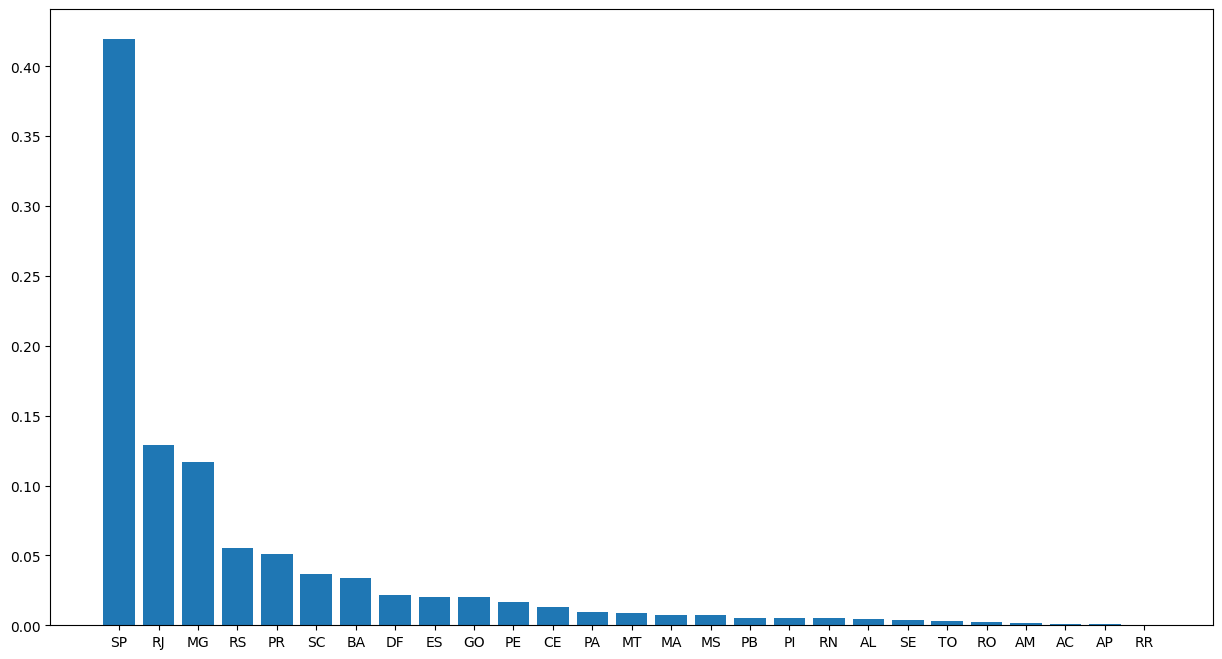

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 8))
states = cs['customer_state'].value_counts(normalize=True)
plt.bar(list(states.index), height=states.values, )
plt.show()
# plt.figure(figsize=(8, 15))
# plt.hist(cs['customer_state'], bins=27, density=True, orientation='horizontal')
# plt.yticks(rotation=True)
# plt.xticks(np.linspace(0, 1, 20))
# plt.show()

we can see that the first 3 states constitute around 70% of customer base

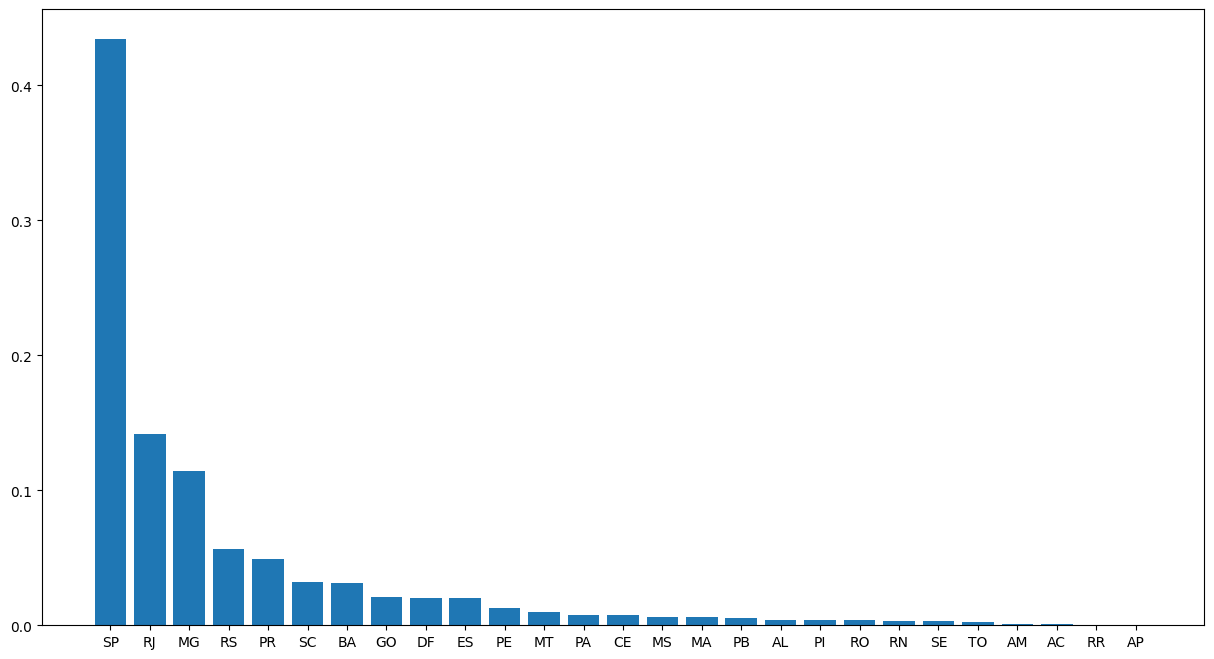

In [8]:
plt.figure(figsize=(15, 8))
states = cool_customers['customer_state'].value_counts(normalize=True)
plt.bar(list(states.index), height=states.values, )
plt.show()

# State, customer, spendings ??
1. Is the average spending significantly different from one state to another

2. are sellers making more profit from same-state orders or across state orders ??

## Average spending

In [9]:
payments_csv_path = os.path.join(DATA_FOLDER, 'olist_order_payments_dataset.csv')
payments = pd.read_csv(payments_csv_path)[['order_id', 'payment_value']]
# make sure to group the payments
payments = payments.groupby('order_id')['payment_value'].agg(['sum']).rename(columns={'sum': 'pay'})

In [10]:
# payments_csv_path = os.path.join(DATA_FOLDER, 'olist_order_payments_dataset.csv')
# payments = pd.read_csv(payments_csv_path)[['order_id', 'payment_value', 'payment_installments']]
# # let's include the payment_installments into the conversation
# payments['pay'] = payments['payment_value'] * payments['payment_installments']
# payments.drop(columns=['payment_value', 'payment_installments'], inplace=True)

# # # we need to make sure to understand how things work here
# # pay_grouped = payments.groupby('order_id')[['payment_installments']].agg(["mean", "count"])
# # # pay_grouped.head()
# # pay_grouped[pay_grouped[('payment_installments', 'count')] >= 2]
# payments.head()

In [11]:
orders_csv_path = os.path.join(DATA_FOLDER, 'olist_orders_dataset.csv')
orders = pd.read_csv(orders_csv_path)
orders = orders[['order_id', 'customer_id']]
orders.head()

,order_id,customer_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c


In [12]:
left = pd.merge(left=orders, right=payments, on='order_id', how='inner')
right = cs[['customer_id', 'customer_state']]
order_customer_pay = pd.merge(left=left, right=right, on='customer_id', how='inner')
order_customer_pay.head()

customer_pay = order_customer_pay[['pay', 'customer_state']]
# let's consider the average spending of 2 thirds of the customers residing in the largest 3 states in Brazil !!!

sp_pay = customer_pay[customer_pay['customer_state'] == 'SP']['pay']
mg_pay = customer_pay[customer_pay['customer_state'] == 'MG']['pay']
rj_pay = customer_pay[customer_pay['customer_state'] == 'RJ']['pay']


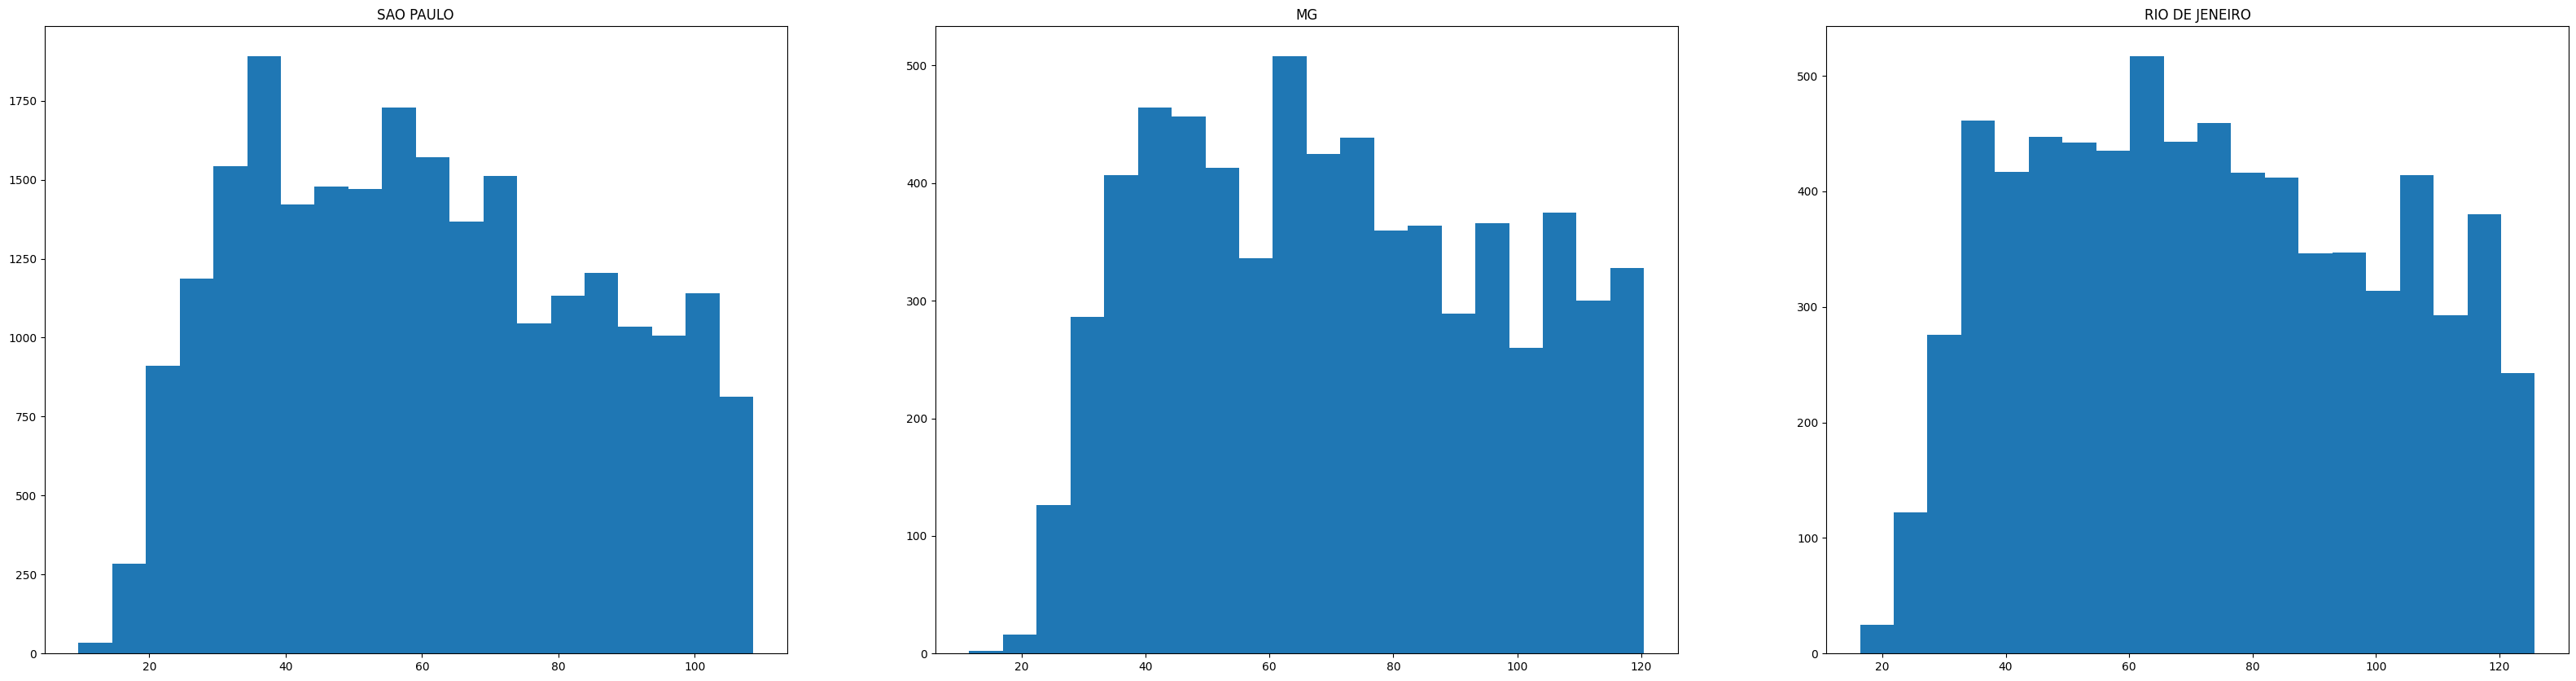

In [13]:
from typing import Sequence

# let's plot the histogram
# we can remove the outliers and determine whether this distribution is normal or not !!
def remove_outliers(x: Sequence):
    # this function simply removes any element that lies outside of the range  (q1 - 0.5 * IQR, q3 + 0.5 * IQR)
    q1, q3 = np.quantile(x, [0.25, 0.75])   
    iqr = q3 - q1
    return sorted([value for value in x if q1 - 0.5 * iqr <= value <= q1 + 0.5 * iqr])

sp_pay_filtered = remove_outliers(sp_pay)
mg_pay_filtered = remove_outliers(mg_pay)
rj_pay_filtered = remove_outliers(rj_pay)

# let's display the distribution
fig = plt.figure(figsize=(40, 10)) 
fig.add_subplot(1, 3, 1)
plt.hist(sp_pay_filtered, bins=20)
plt.title('SAO PAULO')

fig.add_subplot(1, 3, 2)
plt.hist(mg_pay_filtered, bins=20)
plt.title('MG')

fig.add_subplot(1, 3, 3)
plt.hist(rj_pay_filtered, bins=20)
plt.title("RIO DE JENEIRO")
plt.show()

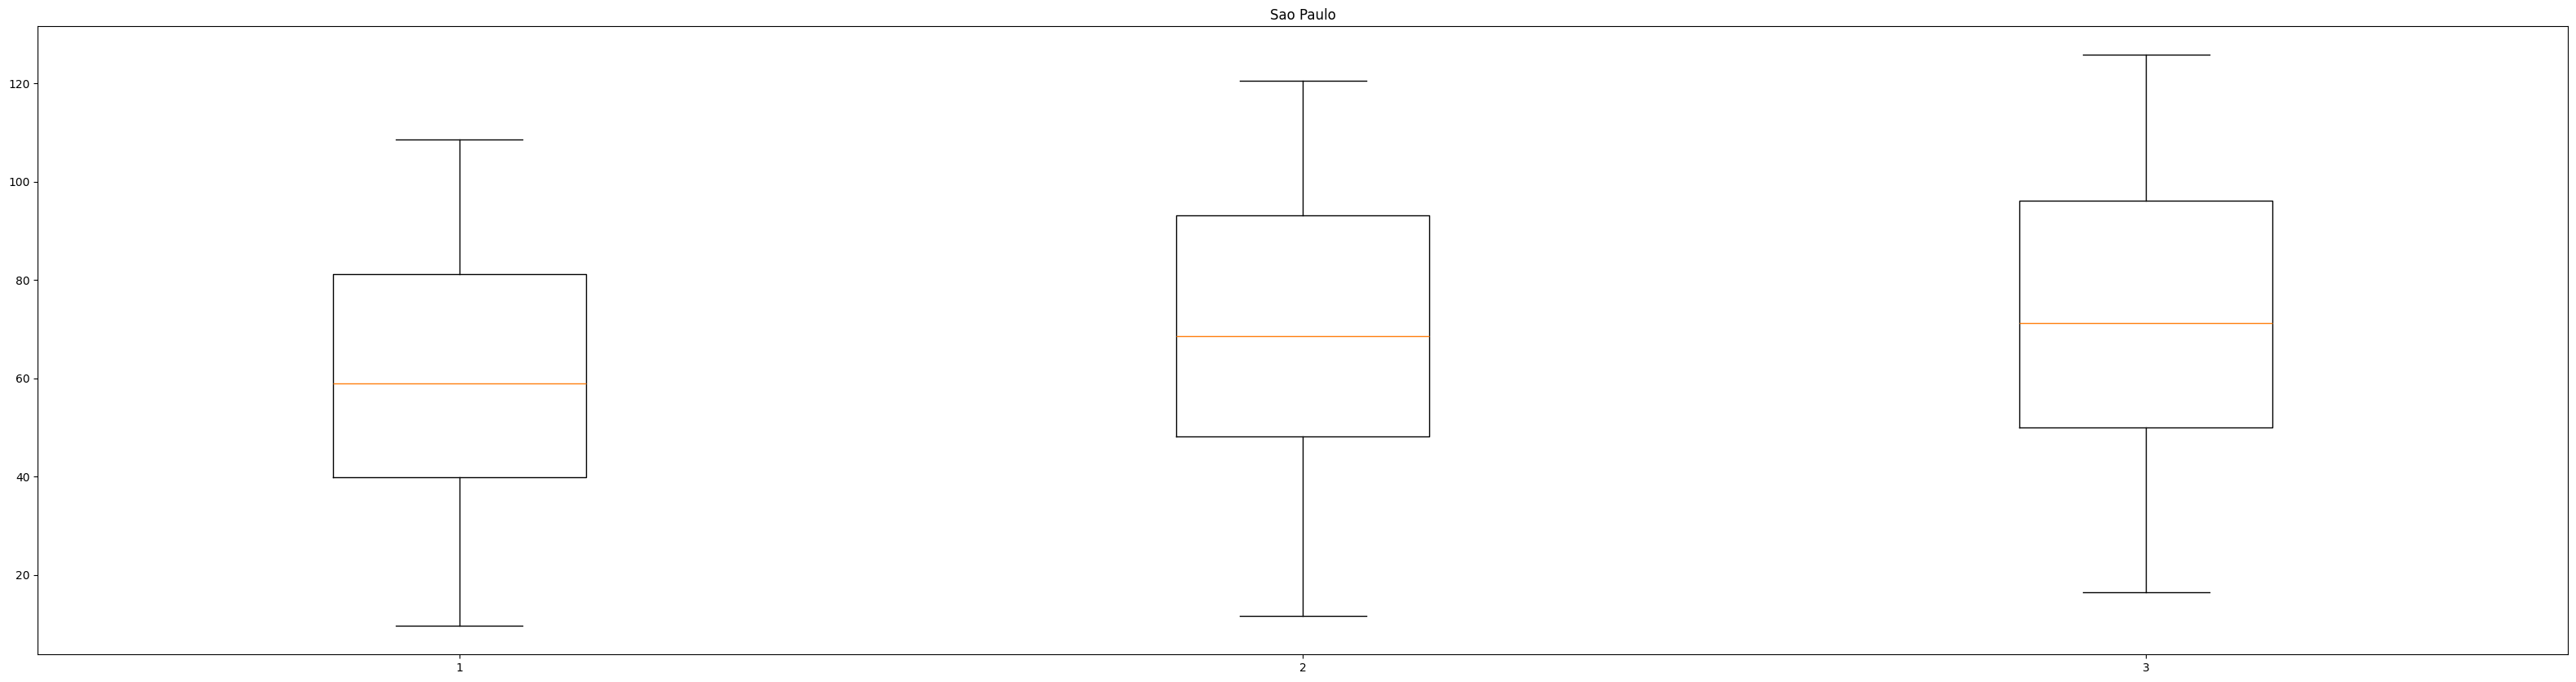

In [14]:
fig = plt.figure(figsize=(40, 10)) 
# fig.add_subplot(1, 3, 1)
# plot the emperical cdf
plt.boxplot([sp_pay_filtered, mg_pay_filtered, rj_pay_filtered])
plt.title('Sao Paulo')

# fig.add_subplot(1, 3, 2)
# # plot the emperical cdf
# plt.boxplot(mg_pay_filtered)
# plt.title('MG')

# fig.add_subplot(1, 3, 3)
# # plot the emperical cdf
# plt.boxplot(rj_pay_filtered)
# plt.title('RIO DE JANEIRO')
plt.show()

In [15]:
# TODO: try to prove normal distribution with a test!!

so far the visualization suggests that there is no significant difference in the average speding of the residents of 'SP' and those of 'RJ'

## Same-state profits VS cross-state Prices

In [ ]:
item_order_csv = os.path.join(DATA_FOLDER, 'olist_order_items_dataset.csv')
order_items = pd.read_csv(item_order_csv)
order_items.head()

In [27]:
prods_per_seller = order_items.groupby('product_id')['seller_id'].agg(lambda x: len(np.unique(x))).sort_values(ascending=False)

In [30]:
multi_seller_products = (prods_per_seller[prods_per_seller > 1]).index.tolist()

In [32]:
# let's extract only the orders with these products
multi_seller_orders = order_items[order_items['product_id'].isin(multi_seller_products)]
len(multi_seller_orders['seller_id'].unique())

786

In [16]:
# in order to calculate the seller's profits on a given order, we first need to calculate the cost. According to the data description of the 'order_items.csv',
# the value of the order is the sum of the 'price' and the 'freight value' for each item in the order

item_order_csv = os.path.join(DATA_FOLDER, 'olist_order_items_dataset.csv')
order_items = pd.read_csv(item_order_csv)
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [19]:
# to simplify the problem a bit, let's consider only orders with only one item
order_items_count = order_items.groupby('order_id')['order_id'].agg(['count'])
ois = pd.merge(order_items_count, order_items, how='inner', on='order_id')
ois = ois[ois['count'] == 1]
ois['value'] = ois['price'] + ois['freight_value']
ois.drop(columns=['order_item_id', 'shipping_limit_date', 'price', 'freight_value', 'count'],inplace=True)
ois.head()

,order_id,product_id,seller_id,value
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,72.19
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,259.83
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,216.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,218.04


In [20]:
# let's map the payments to the orders
payments

,pay
order_id,
00010242fe8c5a6d1ba2dd792cb16214,72.19
00018f77f2f0320c557190d7a144bdd3,259.83
000229ec398224ef6ca0657da4fc703e,216.87
00024acbcdf0a6daa1e931b038114c75,25.78
00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...
fffc94f6ce00a00581880bf54a75a037,343.40
fffcd46ef2263f404302a634eb57f7eb,386.53
fffce4705a9662cd70adb13d4a31832d,116.85


it seems that the average spending is not significantly different across the 3 abovementioned regions

In [ ]:
# time to display the results
fig = plt.figure(figsize=(40, 10)) 

fig.add_subplot(1, 3, 1)
# plot the emperical cdf
plot_ecdf(x=x10, y=e10(x10), show=False)
# plot the theoretical distribution
plt.plot(x10, expo_rv.cdf(x10), label='theoretical')

# plot the quantiles with vertical lines
for x, y, c in zip(q10x, [0.25, 0.5, 0.75], ['r', 'b', 'g']) :
    plt.axvline(x = x, label = f'{y}-th quantiles', linestyle='--', c=c)

plt.yticks(np.linspace(0, 1, 21))
# plot the original cdf
plt.legend()
plt.title('10 samples')


In [24]:
item_order_csv = os.path.join(DATA_FOLDER, 'olist_order_items_dataset.csv')
order_items = pd.read_csv(item_order_csv)
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [25]:
left = pd.merge(orders, payments, how='inner', on='order_id')
right = order_items[['order_id', 'product_id', 'price']]
order_customer_payment = pd.merge(left=left, right=right, how='inner', on='order_id')
order_customer_payment.head()

,order_id,customer_id,pay,product_id,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,38.71,87285b34884572647811a353c7ac498a,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,141.46,595fac2a385ac33a80bd5114aec74eb8,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,179.12,aa4383b373c6aca5d8797843e5594415,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,72.20,d0b61bfb1de832b15ba9d266ca96e5b0,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,28.62,65266b2da20d04dbe00c5c2d3bb7859e,19.90


In [16]:
item_order_csv = os.path.join(DATA_FOLDER, 'olist_order_items_dataset.csv')
order_items = pd.read_csv(item_order_csv)
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [17]:
orders_csv_path = os.path.join(DATA_FOLDER, 'olist_orders_dataset.csv')
orders = pd.read_csv(orders_csv_path)
orders = orders[['order_id', 'customer_id']]
orders.head()

,order_id,customer_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c


In [25]:
left = pd.merge(orders, order_items, how='inner', on='order_id')[['order_id', 'customer_id', 'product_id', 'price']]
right = cs[['customer_id', 'customer_state']] 
order_product_customer = pd.merge(left=left, right=right,how='inner', on='customer_id')
order_product_customer.head()

,order_id,customer_id,product_id,price,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,118.70,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,aa4383b373c6aca5d8797843e5594415,159.90,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,65266b2da20d04dbe00c5c2d3bb7859e,19.90,SP
